In [17]:
from pathlib import Path
import pickle
import argparse
import jax
from jax import jit, device_put
import jax.numpy as jnp
from jax import random
from tqdm import tqdm
import optax
from numpyro.infer import SVI, Trace_ELBO
import numpy as np
import matplotlib.pyplot as plt

from src.models.CCVAE import CCVAE
from src.models.encoder_decoder import MNISTEncoder, MNISTDecoder, CIFAR10Encoder, CIFAR10Decoder, CELEBADecoder, CELEBAEncoder, get_encoder_decoder
from src.data_loading.loaders import get_data_loaders
from src.losses import CCVAE_ELBO
from src.models.config import get_config
from numpyro.infer import Predictive

In [29]:
# Set up random seed
seed = 42

# DATASET
dataset_name = "CELEBA" #"MNIST" # use "CIFAR10"

config = get_config(dataset_name)
encoder_class, decoder_class = get_encoder_decoder(dataset_name)

distribution = config["distribution"]

cmap = "gray" if dataset_name == "MNIST" else None
# Data loading

img_shape, loader_dict, size_dict = get_data_loaders(dataset_name=dataset_name, 
                                          p_test=0.2, 
                                          p_val=0.2, 
                                          p_supervised=0.05, 
                                          batch_size=64, 
                                          num_workers=6, 
                                          seed=seed)


scale_factor = config['scale_factor'] * size_dict["supervised"] # IMPORTANT, maybe run a grid search (0.3 on cifar)

# Set up model
ccvae = CCVAE(encoder_class, 
               decoder_class, 
               config['num_classes'],
               config['latent_dim'], 
               img_shape, 
               distribution=distribution,
               multiclass=config['multiclass'],
)
print("Model set up!")

Successfully loaded CELEBA dataset.
Total num samples 202599
Num test samples: 40519
Num validation samples: 32416
Num supervised samples: 6483
Num unsupervised samples: 123181
Model set up!


In [30]:
batch = next(iter(loader_dict["validation"]))

In [31]:
with open("./model_weights/ccvae" + dataset_name + ".pkl", 'rb') as file:
    params=pickle.load(file)

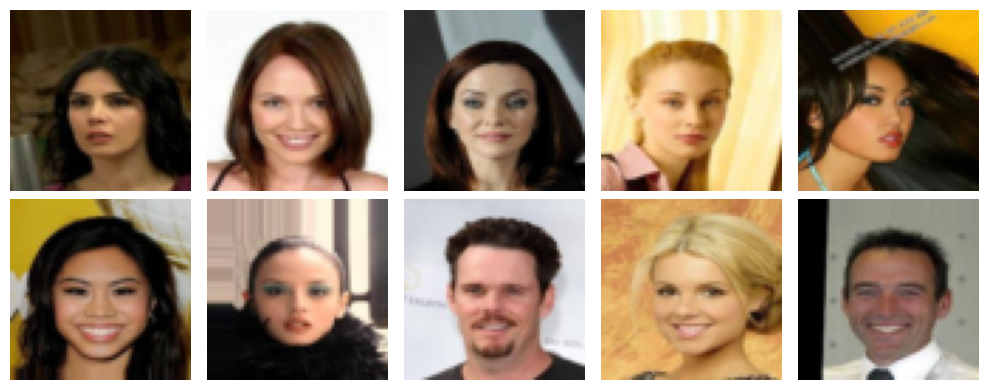

In [32]:
#xs = jnp.zeros((10,) + img_shape)
#ys = jnp.array([i for i in range(10)])


# OR 
load = iter(loader_dict["test"])
xs, ys = next(load)

n_rows = 2
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        image = xs[i * n_cols + j]
        
        if dataset_name == "MNIST":
            image = image.squeeze(-1)
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [33]:
print(xs.shape, ys.shape)

(64, 64, 64, 3) (64, 40)


In [34]:
ccvae.latent_class

40

In [36]:
predictive = Predictive(ccvae.model_supervised, guide=ccvae.guide_supervised, params=params, num_samples=25, return_sites=["loc", "zs"])

rng_key = jax.random.PRNGKey(0) 
predictions = predictive(rng_key, xs, ys)

loc = predictions['loc']
zs = predictions['zs']

print(loc.shape, zs.shape)

KeyError: 'zs'

In [38]:
class_number = 3

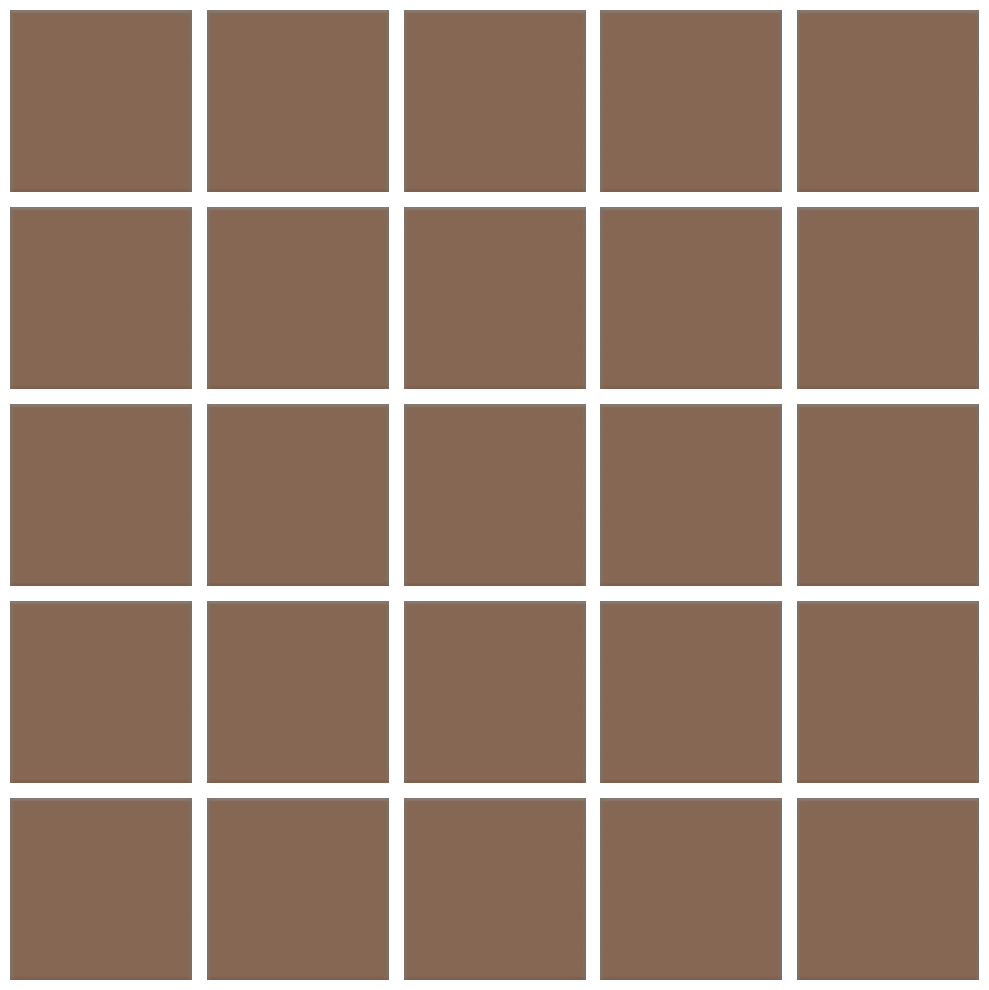

In [39]:
n_rows = 5
n_cols = 5

plt.figure(figsize=(n_cols * 2, n_rows * 2))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    image = loc[i, class_number]

    if dataset_name == "MNIST":
        image = image.squeeze(-1)
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.axis('off')  # Turn off the axis labels

# Adjust layout and show the plot
plt.tight_layout()
plt.show()